## PreProcessing Step
### the following issues need to be handled
1. some images are inverted (white is used for font and black for background unlike the majority)
2. light differs (you need to binarize and enhance the image quality)



In [1]:
from preprocessing import *
from feature_extraction import *
import torch
from torch import nn, optim
from nn_utils import nn_train, nn_predict, nn_accuracy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
classes = ['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']

In [3]:
X, Y = load_data()
Y = Y - 1
print(X.shape)
print(Y.shape)

(1685,)
(1685,)


(244, 341)
The ground-truth value of this image is:  mohakek


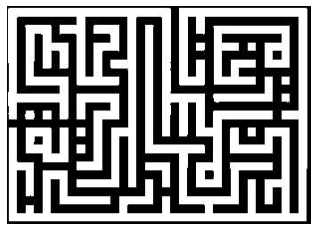

In [4]:
random_index = np.random.randint(0, 1683)

# Plot the image.
print(X[random_index].shape)
plt.imshow(X[random_index], 'gray')
plt.axis("off")

print("The ground-truth value of this image is: ",
      classes[Y[random_index]-1])

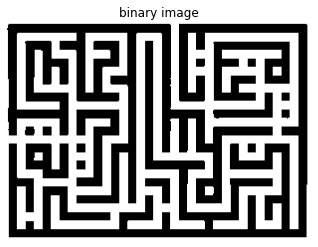

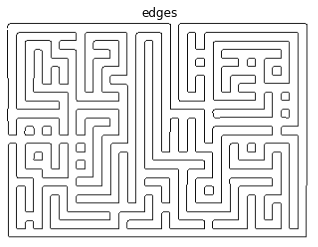

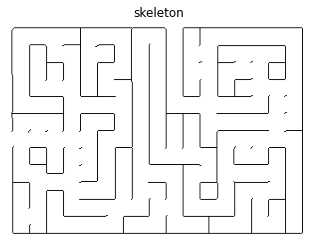

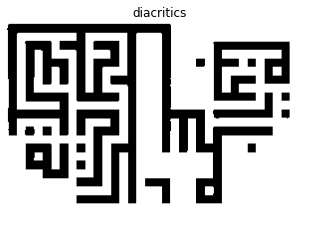

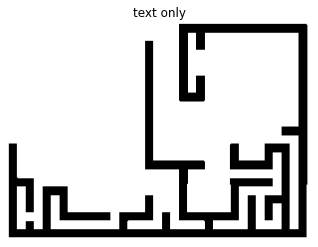

In [5]:
binaryImage = binraization(X[random_index])
edges, skeleton, textOnly, diacritics = extractImagesSet(binaryImage//255)

plt.imshow(binaryImage, 'gray')
plt.title('binary image')
plt.axis("off")
plt.show()


plt.imshow(edges, 'gray')
plt.title('edges')
plt.axis("off")
plt.show()

plt.imshow(skeleton, 'gray')
plt.title('skeleton')
plt.axis("off")
plt.show()

plt.imshow(diacritics, 'gray')
plt.title('diacritics')
plt.axis("off")
plt.show()

plt.imshow(textOnly, 'gray')
plt.title('text only')
plt.axis("off")
plt.show()

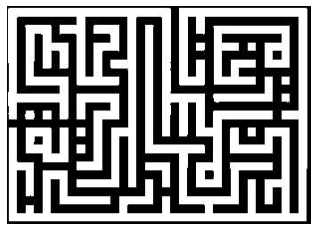

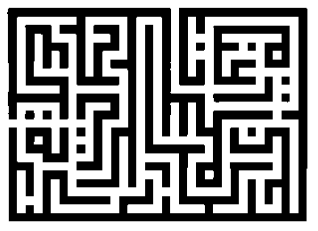

[0.58562874 0.98023952 0.51916168 0.20958084 0.56886228 0.72155689
 0.42694611 0.3502994  0.57784431 0.63413174 0.40838323 0.40718563
 0.60479042 0.57185629 0.34131737 0.41497006 0.70958084 0.57125749
 0.19760479 0.43952096 0.8011976  0.55449102 0.29101796 0.51257485
 0.66586826 0.40179641 0.23053892 0.54790419 0.62814371 0.42215569
 0.36946108 0.68802395 0.68862275 0.31437126 0.32634731 0.6257485
 0.57365269 0.38323353 0.42994012 0.61077844 0.48502994 0.29640719
 0.44730539 0.67365269 0.45284431 0.24251497 0.24251497 1.
 1.         0.25      ]


In [6]:
img = X[random_index].copy()

plt.imshow(img, 'gray')
plt.axis("off")
plt.show()

binaryImage = binraization(img)
plt.imshow(binaryImage, 'gray')
plt.axis("off")
plt.show()

print(horizontalProfileProjection(binaryImage, 50))

In [25]:
feature_dim = 360
features = np.zeros((X.shape[0], feature_dim))
for i in range(X.shape[0]):
    X[i] = binraization(X[i])

    # edges, skeleton, textOnly, diacritics = extractImagesSet(X[i] // 255)
    features[i] = extract_EOH(X[i], feature_dim)

# features, labels = [], []

# for i in range(X.shape[0]):
#     X[i] = binraization(X[i])
# #     Xi_textOnly, _ = diacriticsSegmentationClustering(X[i]//255)
#     features.append(extract_hog_features(X[i]))
# #     features.append(extract_hog_features(Xi_textOnly*255))
# #     labels.append(Y[i])
# #     labels.append(Y[i])

# features = np.asarray(features)
# # labels = np.asarray(labels)
# print(features.shape)
# # print(labels.shape)

In [31]:
print(X.shape)
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data(features, Y)

(1685,)


In [32]:
# print(X_train.shape, Y_train.shape)
# print(X_valid.shape, Y_valid.shape)
# print(X_test.shape, Y_test.shape)

# features, labels = [], []

# for i in range(X_train.shape[0]):
#     X_train[i] = binraization(X_train[i])
#     Xi_textOnly, _ = diacriticsSegmentationClustering(X_train[i]//255)
#     features.append(extract_hog_features(X_train[i]))
#     features.append(extract_hog_features(Xi_textOnly*255))
#     labels.append(Y_train[i])
#     labels.append(Y_train[i])

# features = np.asarray(features)
# labels = np.asarray(labels)

# features_valid, labels_valid = [], []

# for i in range(X_valid.shape[0]):
#     X_valid[i] = binraization(X_valid[i])
#     Xi_textOnly, _ = diacriticsSegmentationClustering(X_valid[i]//255)
#     features_valid.append(extract_hog_features(X_valid[i]))
#     features_valid.append(extract_hog_features(Xi_textOnly*255))
#     labels_valid.append(Y_valid[i])
#     labels_valid.append(Y_valid[i])


# features_valid = np.asarray(features_valid)
# labels_valid = np.asarray(labels_valid)
    
# features_test, labels_test = [], []

# for i in range(X_test.shape[0]):
#     X_test[i] = binraization(X_test[i])
#     Xi_textOnly, _ = diacriticsSegmentationClustering(X_test[i]//255)
#     features_test.append(extract_hog_features(X_test[i]))
#     features_test.append(extract_hog_features(Xi_textOnly*255))
#     labels_test.append(Y_test[i])
#     labels_test.append(Y_test[i])

# features_test = np.asarray(features_test)
# labels_test = np.asarray(labels_test)

# print(features.shape, labels.shape)
# print(features_valid.shape, labels_valid.shape)
# print(features_test.shape, labels_test.shape)

In [33]:
X_train = torch.from_numpy(X_train)
print(X_train.shape)
Y_train = torch.from_numpy(Y_train)
print(Y_train.shape)
X_valid = torch.from_numpy(X_valid)
print(X_valid.shape)
Y_valid = torch.from_numpy(Y_valid)
print(Y_valid.shape)
X_test = torch.from_numpy(X_test)
print(X_test.shape)
Y_test = torch.from_numpy(Y_test)
print(Y_test.shape)

torch.Size([1011, 360])
torch.Size([1011])
torch.Size([337, 360])
torch.Size([337])
torch.Size([337, 360])
torch.Size([337])


In [34]:
# X_train.double().dtype

Epoch: 1/400 Training Loss: 0.002174618454054956 validation Loss: 0.006522117099705365 Test Loss: 0.006471887186656013
Epoch: 11/400 Training Loss: 0.001474855797462954 validation Loss: 0.0044492960683669815 Test Loss: 0.004215834048806029
Epoch: 21/400 Training Loss: 0.001018394230617142 validation Loss: 0.00273252718526461 Test Loss: 0.002606796404728196
Epoch: 31/400 Training Loss: 0.0006030774965484348 validation Loss: 0.0017701583729299664 Test Loss: 0.0015858615187579871
Epoch: 41/400 Training Loss: 0.0004419123147762612 validation Loss: 0.001338724035891298 Test Loss: 0.0012000864620378535
Epoch: 51/400 Training Loss: 0.00032830356254539905 validation Loss: 0.0009784752431184673 Test Loss: 0.0008507800738960063
Epoch: 61/400 Training Loss: 0.00026155546911864086 validation Loss: 0.0007887700191237453 Test Loss: 0.0007085738266964694
Epoch: 71/400 Training Loss: 0.00021064731004094277 validation Loss: 0.0006504653115654558 Test Loss: 0.0005895506911178724
Epoch: 81/400 Training L

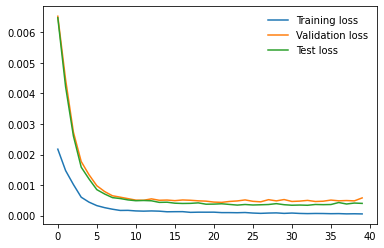

training accuracy = 98.61523244312562%
validation accuracy = 95.25222551928783%
test accuracy = 95.84569732937686%


In [36]:
from nn_utils import *

model = nn.Sequential(nn.Linear(feature_dim, 1024),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(1024, 512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512, 9),
                    nn.LogSoftmax(dim=1))

train_losses, validation_losses, test_losses =\
    nn_train(model, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, epochs=400, lr=0.01)

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)
plt.show()

train_predictions = nn_predict(model, X_train)
validation_predictions = nn_predict(model, X_valid)
test_predictions = nn_predict(model, X_test)

print(f'training accuracy = {nn_accuracy(train_predictions, Y_train) * 100}%')
print(f'validation accuracy = {nn_accuracy(validation_predictions, Y_valid) * 100}%')
print(f'test accuracy = {nn_accuracy(test_predictions, Y_test) * 100}%')

In [24]:
from sklearn import svm, metrics

poly = svm.SVC(kernel = 'poly', C=1, degree=4, decision_function_shape='ovo').fit(X_train, Y_train)

train_predictions = poly.predict(X_train)
validation_predictions = poly.predict(X_valid)
test_predictions = poly.predict(X_test)

print(f'training accuracy = {metrics.accuracy_score(Y_train, train_predictions) * 100}%')
print(f'validation accuracy = {metrics.accuracy_score(Y_valid, validation_predictions) * 100}%')
print(f'test accuracy = {metrics.accuracy_score(Y_test, test_predictions) * 100}%')

training accuracy = 93.27398615232443%
validation accuracy = 90.50445103857567%
test accuracy = 92.28486646884274%
